In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

In [26]:
train_df = pd.read_csv('training.csv') # split for test and train set is ready
test = pd.read_csv('test.csv')

## Splitting the data first

In [27]:
our_columns = list(set([1,10,11]+(list(range(18, 29))) + [12,14,15,16,17,29,30,31,32,33]))
df = train_df.iloc[:,our_columns]

y = df["IsBadBuy"]
X = df

del X["IsBadBuy"]

In [28]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)


train = pd.DataFrame(X_train.join(y_train))
val = X_val.join(y_val)

In [29]:
val.head()

,Color,Transmission,WheelTypeID,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,...,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
10580,BLUE,AUTO,2.0,78883,OTHER ASIAN,MEDIUM,OTHER,4516.0,5335.0,7121.0,...,8885.0,NaN,NaN,18822,77041,TX,5685.0,0,569,0
27667,GOLD,AUTO,1.0,79278,AMERICAN,CROSSOVER,CHRYSLER,8500.0,10607.0,9680.0,...,11956.0,NaN,NaN,5546,32824,FL,6645.0,0,1857,0
60595,GREEN,AUTO,1.0,92111,AMERICAN,SMALL SUV,FORD,3402.0,4477.0,6513.0,...,7897.0,NaN,NaN,23359,92337,CA,5480.0,0,1353,0
60484,RED,AUTO,1.0,85427,AMERICAN,MEDIUM SUV,CHRYSLER,9959.0,11383.0,11256.0,...,13878.0,NaN,NaN,23359,91752,CA,8375.0,0,1763,0
48363,GOLD,AUTO,1.0,82274,AMERICAN,VAN,GM,7026.0,8385.0,11809.0,...,14091.0,NaN,NaN,18111,47129,IN,6475.0,0,2282,0


In [30]:
train.columns

Index(['Color', 'Transmission', 'WheelTypeID', 'VehOdo', 'Nationality', 'Size',
       'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'PRIMEUNIT', 'AUCGUART', 'BYRNO',
       'VNZIP1', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost',
       'IsBadBuy'],
      dtype='object')

In [31]:
train.groupby("Color")["IsBadBuy"].agg(["mean","count"]) # wygląda na to ze not avaiable color zwiększa szanse zlego zakupu, zas pomaranczowy kolor w dziwny sposob zmniejsza - ale jest tam dosyc malo danych

,mean,count
Color,,
BEIGE,0.139706,1088
BLACK,0.113936,5389
BLUE,0.115784,7229
BROWN,0.132890,301
GOLD,0.142626,3702
GREEN,0.118362,2222
GREY,0.116101,5478
MAROON,0.135135,1443
NOT AVAIL,0.253731,67


In [32]:
# na razie damy tylko kolumne czy jest bardziej niebezpieczna czy nie

color_train = train.groupby("Color")["IsBadBuy"].agg(["mean"]) 

max_mean_color = color_train["mean"].max()
color_dict = color_train["mean"].to_dict()
train["ColorDanger"] = train["Color"].map(color_dict).fillna(train.IsBadBuy.mean())/max_mean_color
bad_colors = list(color_train.loc[color_train["mean"] > train.IsBadBuy.mean()].index)

train['DangerousColor'] = np.where(train["Color"].isin(bad_colors), 1, 0)

przygotowanie imputacji

In [33]:
# zaimputujemy sobie wartość 0 dla kolumn MMRCurrentAuctionAveragePrice oraz MMRAcquisitionAuctionAveragePrice
# pozostałe wywalamy
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

train["MMRCurrentAuctionAveragePrice"] = np.where(train["MMRCurrentAuctionAveragePrice"] == 0, np.nan, train["MMRCurrentAuctionAveragePrice"])
train["MMRAcquisitionAuctionAveragePrice"] = np.where(train["MMRAcquisitionAuctionAveragePrice"] == 0, np.nan, train["MMRAcquisitionAuctionAveragePrice"])

imp_mean = IterativeImputer(random_state=0)

MMR_columns = ["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"]

imp_mean.fit(train[MMR_columns])

MMR_train_transformed = imp_mean.transform(train[MMR_columns])
MMR_train_transformed = pd.DataFrame(MMR_train_transformed, columns = MMR_columns)
MMR_train_transformed.index = train.index
MMR_train_transformed

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,MMRCurrentAuctionAveragePrice,MMRAcquisitionAuctionAveragePrice,VehBCost
51596,6473.0,5602.0,6800.0
7358,8975.0,7038.0,10775.0
66010,6680.0,6680.0,6890.0
39674,6416.0,5820.0,6870.0
12486,5978.0,4836.0,7350.0
...,...,...,...
22569,8529.0,8168.0,6470.0
41811,3769.0,3720.0,5935.0
67791,6346.0,5560.0,7130.0
40656,5345.0,5512.0,8370.0


In [35]:
train_df

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72978,73010,1,12/2/2009,ADESA,2001,8,MERCURY,SABLE,GS,4D SEDAN GS,...,4836.0,5937.0,NaN,NaN,18111,30212,GA,4200.0,0,993
72979,73011,0,12/2/2009,ADESA,2007,2,CHEVROLET,MALIBU 4C,LS,4D SEDAN LS,...,10151.0,11652.0,NaN,NaN,18881,30212,GA,6200.0,0,1038
72980,73012,0,12/2/2009,ADESA,2005,4,JEEP,GRAND CHEROKEE 2WD V,Lar,4D WAGON LAREDO,...,11831.0,14402.0,NaN,NaN,18111,30212,GA,8200.0,0,1893
72981,73013,0,12/2/2009,ADESA,2006,3,CHEVROLET,IMPALA,LS,4D SEDAN LS,...,10099.0,11228.0,NaN,NaN,18881,30212,GA,7000.0,0,1974


# Preparing functions for pipeline

In [41]:
train_df = pd.read_csv('training.csv') # split for test and train set is ready
test = pd.read_csv('test.csv')

y = train_df["IsBadBuy"]
X = train_df.drop('IsBadBuy', axis=1)

In [43]:
def preprocess_df(X):
    X['TopThreeAmericanName'] = X['TopThreeAmericanName'].fillna('OTHER')
    X['Size'] = X['Size'].fillna('MEDIUM')
    X['Nationality'] = X['Nationality'].fillna('OTHER')
    X['WheelTypeID'] = X['WheelTypeID'].fillna(1)
    X = X.drop(labels = ['VNZIP1','VNST'],axis=1)
        
    return X

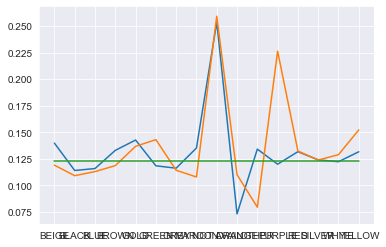

In [53]:
train_bad_buy_mean = train.IsBadBuy.mean()

color_val = val.groupby("Color")["IsBadBuy"].agg(["mean"])
color = color_val.join(color_train, lsuffix="_val", rsuffix="_train")
color["mean"] = train.IsBadBuy.mean()
plt.plot(color.index, color["mean_train"])
plt.plot(color.index, color["mean_val"])
plt.plot(color.index, color["mean"])

plt.show()

In [54]:
def encode_categorical(df):
    df["ColorDanger"] = df["Color"].map(color_dict).fillna(train_bad_buy_mean)/max_mean_color # no takie w miare to jest średnie
    #df['DangerousColor'] = np.where(df["Color"].isin(bad_colors), 1, 0)

    df["IsPrimeunitNA"] = np.where(df["PRIMEUNIT"].isna(), 1, 0) # to moze byc niepotrzebne
    primeunit_dict = {'NO':0, 'YES':1, float("nan"):0} # nie jestem pewien czy nie lepiej bedzie zamienic na odwrot
    df['PRIMEUNIT'] = df['PRIMEUNIT'].str.upper().map(primeunit_dict)
    aucguart_dict = {'GREEN':2, 'YELLOW':1, "RED":0, float("nan"):0}
    df['AUCGUART'] = df['AUCGUART'].str.upper().map(aucguart_dict)

    transmission_dict = {'AUTO':0, 'MANUAL':1}
    df['Transmission'] = df['Transmission'].str.upper().map(transmission_dict)
    df["Transmission"] = df["Transmission"].fillna(df["Transmission"].median())

    df = df.drop(columns=["BYRNO", "Color"])

    print("Categorical columns transformed.")

    return df

def impute_MMR(df):

    # zamieniamy 0 na nan    
    df["MMRCurrentAuctionAveragePrice"] = np.where(df["MMRCurrentAuctionAveragePrice"] == 0, np.nan, df["MMRCurrentAuctionAveragePrice"])
    df["MMRAcquisitionAuctionAveragePrice"] = np.where(df["MMRAcquisitionAuctionAveragePrice"] == 0, np.nan, df["MMRAcquisitionAuctionAveragePrice"])

    MMR_df = imp_mean.transform(df[MMR_columns])
    MMR_df = pd.DataFrame(MMR_df, columns = MMR_columns)
    MMR_df.index = df.index
    df["MMRCurrentAuctionAveragePrice"] = MMR_df["MMRCurrentAuctionAveragePrice"]
    df["MMRAcquisitionAuctionAveragePrice"] = MMR_df["MMRAcquisitionAuctionAveragePrice"]

    df = df.drop(columns = ["MMRAcquisitionAuctionCleanPrice", "MMRAcquisitionRetailAveragePrice", "MMRAcquisitonRetailCleanPrice", 
                            "MMRCurrentAuctionCleanPrice", "MMRCurrentRetailAveragePrice", "MMRCurrentRetailCleanPrice"]) 
    
    # tutaj moze tez MMRAcquisitionAuctionAveragePrice

    print("MMR Columns imputed.")
    return df

In [55]:
def preprocess_df(X):
    X['TopThreeAmericanName'] = X['TopThreeAmericanName'].fillna('OTHER')
    X['Size'] = X['Size'].fillna('MEDIUM')
    X['Nationality'] = X['Nationality'].fillna('OTHER')
    #X = X[X['WheelTypeID'].notna()] TAK NIE WOLNO - to nam psuje preprocessing
    X['WheelTypeID'] = X['TopThreeAmericanName'].fillna(0)

    X = X.drop(labels = ['VNZIP1','VNST'],axis=1)
    
    return X

In [56]:
def assign_chassis(df):

    types = ["CAB", "CONVERTIBLE", "CUV", "HATCHBACK", "PASSENGER", "SEDAN", "SPORT", "SUV", "MINIVAN", "UTILITY", "WAGON"]

    for word in df['SubModel_splited']:
        if word in types:
            return word
    return "OTHER"

def assign_season(df):

    if 3 <= df['Month'] <= 5: val = 'Spring'
    elif 6 <= df['Month'] <= 8: val = 'Summer'
    elif 9 <= df['Month'] <= 11: val = 'Autumn'
    else: val = 'Winter'

    return val

def preprocess(df):

    df['PurchDate'] = pd.to_datetime(df['PurchDate'])
    df['Month'] = df['PurchDate'].dt.month
    df['Year'] = df['PurchDate'].dt.year.apply(lambda x: x == 2010).astype(int)
    df['Season'] = df.apply(assign_season, axis = 1)
    df['Doors'] = df['SubModel'].str.extract(r'([1-9]D)').replace(np.nan, "UNKNOWN")
    df['SubModel_splited'] = df['SubModel'].apply(lambda x: str(x).split())
    df['Chassis'] = df.apply(assign_chassis, axis=1)

    return df

# Making pipeline

In [57]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)


train = X_train.join(y_train)
val = X_val.join(y_val)

In [58]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_val: {X_val.shape}')

Shape of X_train: (51088, 33)
Shape of X_val: (21895, 33)


In [59]:
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of y_train: (51088,)
Shape of y_val: (21895,)


In [60]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['VehOdo','VehBCost', 'WarrantyCost']),
        ('cat', OneHotEncoder(sparse_output=False),  ['TopThreeAmericanName', 'WheelTypeID','Nationality','Size',
                                                      'Make', 'Chassis', 'Doors', 'Auction', 'Season', 'Month']),
        ('passthrough','passthrough', ['IsOnlineSale', 'VehicleAge', 'Year'])
    ])

In [61]:
categorical_transformer = FunctionTransformer(encode_categorical)
MMR_imputer = FunctionTransformer(impute_MMR)
mateusz_transformer = FunctionTransformer(preprocess_df)
maciej_transformer = FunctionTransformer(preprocess)

# all the afore declared processings applied
prepipe = Pipeline([
    ("transform_categorical", categorical_transformer),
    ("MMR_imputing", MMR_imputer), 
    ("Mateusz", mateusz_transformer),
    ("Maciej", maciej_transformer)
])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [62]:
X_train = prepipe.fit_transform(X_train)
X_train = pipeline.fit_transform(X_train)

Categorical columns transformed.
MMR Columns imputed.


In [63]:
X_train

array([[ 0.90092155,  0.03974257,  1.02045083, ...,  0.        ,
         5.        ,  0.        ],
       [ 0.61199229,  2.29599753,  0.22244171, ...,  0.        ,
         6.        ,  0.        ],
       [ 0.0953035 ,  0.09082759, -0.79169488, ...,  0.        ,
         3.        ,  0.        ],
       ...,
       [-1.77211927,  0.22705431, -1.32536349, ...,  0.        ,
         2.        ,  1.        ],
       [-0.36213357,  0.93089233, -0.0934369 , ...,  0.        ,
         7.        ,  0.        ],
       [-1.03397285, -1.0330428 ,  1.14181472, ...,  0.        ,
         8.        ,  1.        ]])

In [ ]:
# validation dataset

X_val = prepipe.transform(X_val)
X_val = pipeline.transform(X_val)


# model selection

to nie dziala ale idk czemu

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [ ]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_val, y_train, y_val)
models

In [ ]:
predictions

random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

In [ ]:
y_pred = rf_model.predict(X_val)

In [ ]:
print(classification_report(y_pred, y_val))

In [ ]:
confusion_matrix(y_val, y_pred)

# final predictions

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
test_columns =  [i - 1 for i in list(set([10,11]+(list(range(18, 29))) + [12,14,15,16,17,29,30,31,32,33]))] 

X_test = test.iloc[:, test_columns].copy()
X_test

In [ ]:
X_test = prepipe.transform(X_test)
X_test = pipeline.transform(X_test)

In [ ]:
y = rf_model.predict(X_test)
pd.DataFrame(y, columns=["IsBadBuy"]).join(test["RefId"]).to_csv("out.csv", index=False)